In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#create linear regression model

#IMPORTANT NOTICE!
'''
########################################
This is taken from Homework 2 assignment
########################################
'''
def sums(x, y):
    '''
    This function creates all the necessary sums for the linear regression equations
    Inputs:
        x (np array) data that will be used to make predictions
        y (np array) data that will be used to check predictions
    Outputs:
        sum_x (float) sum of all the x values
        sum_y (float) sum of all the y values
        sum_x2 (float) sum of all the squared x values
        sum_xy (float) sum of all the x values multiplied by their respective y values
    '''
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x*y)
    return sum_x, sum_y, sum_x2, sum_xy

In [3]:
#Also from Homework 2
def B_i(x,y):
    '''
    This function calculates the slope (B_1) and intercept (B_0) of the regression
    Inputs:
        x (np array) data that will be used to make predictions
        y (np array) data that will be used to check predictions
    Outputs:
        B1 (float) slope of the regression
        B0 (float) intercept for the regression
    '''
    sum_x, sum_y, sum_x2, sum_xy = sums(x,y)
    numerator = ((len(x) * sum_xy) - (sum_x * sum_y))
    denominator = ((len(x) * sum_x2) - (sum_x**2))
    B1 = numerator/denominator
    B0 = (sum_y - (B1 * sum_x)) / len(x)
    return B1, B0

In [155]:
#The ridge regression is based on the gradient descent from homework 4
#It works on matrices so that if you wanted more predictors it would be easy to expand it
def ridge_regression(x, y, Lr=0.1, penalty=0.1, epochs=10000):
    '''
    This function does a gradient descent for ridge regression.
    input:
        x: np array, predictor values
        y: np array, target values
        lr: float, learning rate
        lambda: float, ridge regularization strength
        epochs: int, number of iterations
    output:
        B0:float, intercept
        B1: float, slope
    '''
    m, n = x.shape  # m = number of samples, n = number of features
    slope = []
    intercept = []
    #My B_i fxn is meant for only one predictor so if i want to expand it to a matrix it will need to change a bit
    for i in range(n):
        B1, B0 = B_i(x[:,i], y[i])  # Apply B_i for each row of X
        slope.append(B1)
        intercept.append(B0)
    B = np.zeros((n+1, 1))  # Initialize weights
    #B[0] = intercept  # The first row is for intercepts
    #B[1:] = np.array(slope).reshape(-1, 1)  # The rest are for slopes

    #need a column in X of ones to account for B having the intercept
    x_B = np.ones((m,n+1))
    x_B[:,1:] = x

    for epoch in range(epochs):
        Y_pred = np.dot(x_B, B)
        err = Y_pred - y

        B_pen = np.copy(B)
        B_pen[0] = 0
        
        dB = (1/m) * (np.dot(x_B.T, err) + penalty * B_pen)
        B -= Lr * dB

    return B

[https://www.kaggle.com/code/ninjaac/lasso-and-ridge-regression-from-scratch?utm_source=chatgpt.com]

Assisted in building the ridge regression model.. it is kind of hard to follow along with this because it uses a class.
I think I managed to apply my old functions into this method fairly well.

In [178]:
#Now actually start the model
data = pd.read_csv('FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv')
data = data.drop(columns = ['Footnote'])
data = data.dropna()
data['Number of Readmissions'] = data['Number of Readmissions'].astype(float)
print(data.head())
print(data.columns)

                     Facility Name  Facility ID State        Measure Name  \
0  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL   READM-30-AMI-HRRP   
1  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL  READM-30-CABG-HRRP   
2  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL    READM-30-HF-HRRP   
4  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL    READM-30-PN-HRRP   
5  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL  READM-30-COPD-HRRP   

   Number of Discharges  Excess Readmission Ratio  Predicted Readmission Rate  \
0                 296.0                    0.9483                     13.0146   
1                 151.0                    0.9509                      9.6899   
2                 681.0                    1.0597                     21.5645   
4                 490.0                    0.9715                     16.1137   
5                 130.0                    0.9330                     15.4544   

   Expected Readmission Rate  Number of Readmissio

In [184]:
data['Read_Dis_ratio'] = data['Number of Readmissions'] / data['Number of Discharges']
X_both = data['Read_Dis_ratio']
X = data['Number of Discharges']
Y = data['Excess Readmission Ratio']

In [185]:
#Having trouble with the regression working forgot to normalize data
mean_X = np.mean(X)
std_dev_X = np.std(X)
normal_X = (X-mean_X)/std_dev_X

In [186]:
normal_X = np.array(normal_X).reshape(-1,1)
Y = np.array(Y).reshape(-1,1)
print(normal_X.shape, Y.shape)
print(normal_X)


(8121, 1) (8121, 1)
[[ 0.0346441 ]
 [-0.51143691]
 [ 1.48458333]
 ...
 [-0.70350678]
 [-0.56792805]
 [-0.75246577]]


In [187]:
#Testing to see how different param effect the output
B = ridge_regression(normal_X,Y,epochs=300)
print(B)
B = ridge_regression(normal_X,Y,epochs=1000)
print(B)

[[ 1.00923311]
 [-0.0113155 ]]
[[ 1.00923311]
 [-0.0113155 ]]


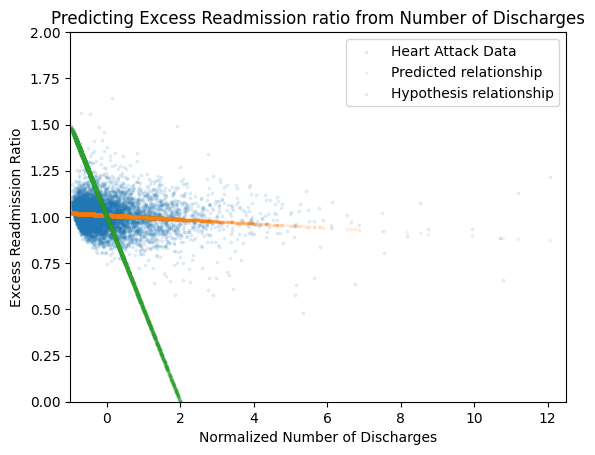

In [193]:
Y_pred = B[0] + B[1]*normal_X
Y_hypo = 1. - 0.5*normal_X
plt.scatter(normal_X, Y, s=3, alpha=0.1, label='Heart Attack Data')
plt.scatter(normal_X, Y_pred, s=3, alpha=0.1, label='Predicted relationship')
plt.scatter(normal_X, Y_hypo, s=3, alpha=0.1, label='Hypothesis relationship')
plt.ylim(0,2)
plt.xlim(-1,12.5)
plt.ylabel('Excess Readmission Ratio')
plt.xlabel('Normalized Number of Discharges')
plt.title('Predicting Excess Readmission ratio from Number of Discharges')
plt.legend()
plt.show()